In [122]:
import pandas as pd
## we load the data
df = pd.read_csv('churn_bank.csv')
NRows, NColumns = df.shape

df['Exited'] = df['Exited'].astype("float")

In [123]:
print(NRows)

10000


### Transforming the database to be tree-able

In [124]:
df = df.convert_dtypes()
df.dtypes
# we can clearly see which variables to "dummify": geography and gender

CustomerId                  Int64
Surname            string[python]
CreditScore                 Int64
Geography          string[python]
Gender             string[python]
Age                         Int64
Tenure                      Int64
Balance                   Float64
NumOfProducts               Int64
HasCrCard                   Int64
IsActiveMember              Int64
EstimatedSalary           Float64
Exited                      Int64
dtype: object

In [125]:
df["Gender"] = (df["Gender"] == "Female").astype(int)
# Females should now be 1, males 0.

In [126]:
#creating new columns and indexing them as not last so that we can easily separate Exit
df.insert(NColumns-1, 'InSpain', (df["Geography"] == "Spain").astype(int))
df.insert(NColumns-1, 'InFrance', (df["Geography"] == "France").astype(int))
df.insert(NColumns-1, 'InGermany', (df["Geography"] == "Germany").astype(int))

In [127]:
df

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,InGermany,InFrance,InSpain,Exited
0,15634602,Hargrave,619,France,1,42,2,0.0,1,1,1,101348.88,0,1,0,1
1,15647311,Hill,608,Spain,1,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,15619304,Onio,502,France,1,42,8,159660.8,3,1,0,113931.57,0,1,0,1
3,15701354,Boni,699,France,1,39,1,0.0,2,0,0,93826.63,0,1,0,0
4,15737888,Mitchell,850,Spain,1,43,2,125510.82,1,1,1,79084.1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,Obijiaku,771,France,0,39,5,0.0,2,1,0,96270.64,0,1,0,0
9996,15569892,Johnstone,516,France,0,35,10,57369.61,1,1,1,101699.77,0,1,0,0
9997,15584532,Liu,709,France,1,36,7,0.0,1,0,1,42085.58,0,1,0,1
9998,15682355,Sabbatini,772,Germany,0,42,3,75075.31,2,1,0,92888.52,1,0,0,1


In [128]:
df.dtypes

CustomerId                  Int64
Surname            string[python]
CreditScore                 Int64
Geography          string[python]
Gender                      int64
Age                         Int64
Tenure                      Int64
Balance                   Float64
NumOfProducts               Int64
HasCrCard                   Int64
IsActiveMember              Int64
EstimatedSalary           Float64
InGermany                   int64
InFrance                    int64
InSpain                     int64
Exited                      Int64
dtype: object

### If we don't worry about how "small" the dataset is

In [129]:
df_Y = df[['Exited']]
df_X = df[df.columns[2:NColumns-1]].drop(["Geography"], axis=1)

In [130]:
#pip install scikit-learn
import sklearn

In [131]:
from sklearn.model_selection import train_test_split
df_X_train, df_X_test, df_Y_train, df_Y_test = train_test_split(df_X,
df_Y,
test_size=0.3,
random_state=0,
stratify=df_Y)

In [132]:
from sklearn.model_selection import StratifiedShuffleSplit
v_split = StratifiedShuffleSplit(n_splits=1, train_size=0.7, random_state=0)

In [133]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=0)
param_grid = {'max_depth': range(1, 11),
              'min_samples_split': [2, 10, 25, 50, 75, 85, 100, 200]}

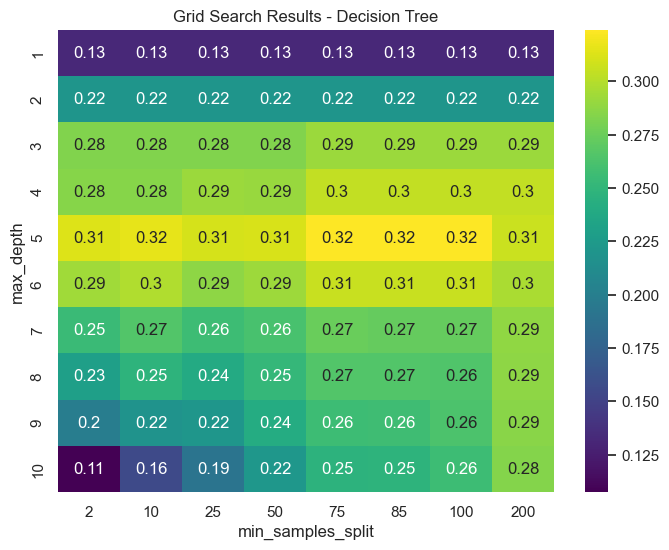

In [134]:
from sklearn.model_selection import GridSearchCV
dt_search = GridSearchCV(dt, param_grid, cv=v_split, n_jobs = -1)
dt_res = dt_search.fit(df_X_train, df_Y_train)

import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame(dt_res.cv_results_['params'])
df['mean_test_score'] = dt_res.cv_results_['mean_test_score']
sns.set_theme()
sns.set(rc={'figure.figsize': (8, 6)})
sns.heatmap(df.pivot_table(index='max_depth', columns='min_samples_split',
values='mean_test_score'),
cmap='viridis', annot=True)
plt.title('Grid Search Results - Decision Tree')
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.show()

# ok since this doesnt work we need to transform the dataset to create dummies

In [135]:
dt_search = GridSearchCV(dt, param_grid, cv=v_split, n_jobs = -1,
                         scoring = "neg_root_mean_squared_error")
dt_res = dt_search.fit(df_X_train, df_Y_train)

In [136]:
from sklearn.metrics import root_mean_squared_error
print(root_mean_squared_error(df_Y_test, dt_res.predict(df_X_test)))

0.33912231644119034
